In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
dataset_path = '../preco_petroleo.csv'
df = pd.read_csv(dataset_path, sep=';', engine='python')
df = df.iloc[:, :-1]

# Convert 'Data' column to datetime format for proper time series handling
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
# Set 'Data' column as index to facilitate time series operations
df.set_index('Data', inplace=True)

# Display dataframe information
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6924 entries, 2004-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Preco   6924 non-null   float64
dtypes: float64(1)
memory usage: 108.2 KB


,Preco
Data,
2004-01-02,29.17
2004-01-03,30.10
2004-01-04,30.30
2004-01-05,32.30
2004-01-06,29.55


In [3]:
# Check the difference between dates to understand the time series frequency
date_diff = df.index.to_series().diff().value_counts()

# Identify missing dates in the time series
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = all_dates.difference(df.index)

print(date_diff)
print(f'Number of missing dates: {len(missing_dates)}')

Data
1 days    6522
3 days     278
2 days      93
4 days      25
5 days       4
7 days       1
Name: count, dtype: int64
Number of missing dates: 746


The analysis of the differences between dates showed that most intervals are **1 day**, indicating that the data predominantly follows a daily frequency.

However, some larger intervals were identified, such as **2, 3, 4, 5, and even 7 days**. These gaps are likely due to **weekends and public holidays**, which is common in financial time series like oil prices.

A total of **746 missing dates** were identified within the time range. These observations **will be important later** when we decide whether to fill the missing dates or work only with the available days in the dataset.

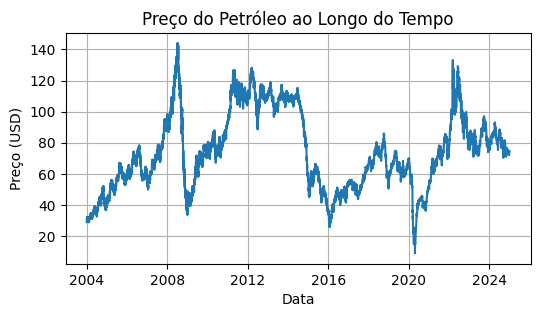

In [4]:
# Plot oil price over time to visually check for trend or variability changes
plt.figure(figsize=(6, 3))
plt.plot(df.index, df['Preco'])
plt.title('Preço do Petróleo ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.grid(True)
plt.show()

In [5]:
# Perform ADF test to check stationarity
adf_test = adfuller(df['Preco'])

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Optional: Check critical values
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.9304533879918435
p-value: 0.04191956552977076
Critical Values:
   1%: -3.431299178358933
   5%: -2.8619594595441695
   10%: -2.566993274459373


The ADF test was applied to check the stationarity of the oil price series.  
The p-value obtained was **0.0419**, which is **below the 0.05 threshold**.  
This result **allows us to reject the null hypothesis** of non-stationarity at the **5% significance level**.  
Therefore, **the series can be considered stationary**, and **no differencing is required** at this point.

In [6]:
def plot_acf_pacf(series, lags=40, title_suffix=''):
    plt.figure(figsize=(5, 3))

    plt.subplot(211)
    plot_acf(series.dropna(), ax=plt.gca(), lags=lags)
    plt.title(f'ACF - {title_suffix}')

    plt.subplot(212)
    plot_pacf(series.dropna(), ax=plt.gca(), lags=lags)
    plt.title(f'PACF - {title_suffix}')

    plt.tight_layout()
    plt.show()

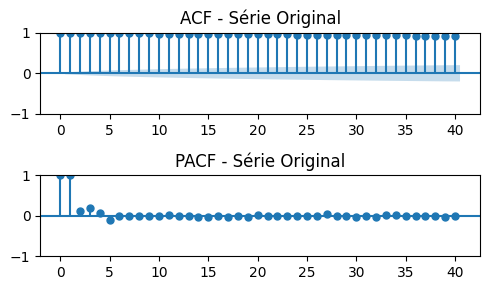

In [7]:
plot_acf_pacf(df['Preco'], title_suffix='Série Original')

The ACF plot for the original series shows a slow, gradual decay, which is a common indication of non-stationarity, despite the ADF test suggesting otherwise.

This behavior suggests the presence of a trend component, indicating that the series may still exhibit some degree of non-stationarity.  
To ensure proper model performance, we will apply **differencing (d=1)** to remove any residual trend and achieve stationarity.

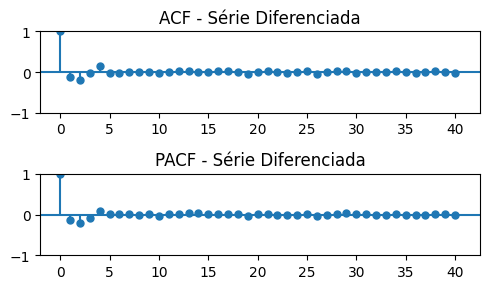

In [8]:
df['Preco_diff'] = df['Preco'].diff().dropna()
plot_acf_pacf(df['Preco_diff'], title_suffix='Série Diferenciada')

After applying first-order differencing, the ACF plot no longer exhibits the slow decay pattern. Instead, it quickly cuts off after lag 1, and the PACF plot also shows significance only at lag 1.

This is a strong indication that the differencing successfully removed the trend component, making the series stationary.  
We can now proceed to model the series with **d=1** and evaluate the appropriate values for **p** and **q**.

In [9]:
# Fit ARIMA(1, 1, 1) model
arima_model = ARIMA(df['Preco'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Print summary of the ARIMA model
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Preco   No. Observations:                 6924
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13760.196
Date:                Sun, 16 Feb 2025   AIC                          27526.393
Time:                        19:34:52   BIC                          27546.921
Sample:                             0   HQIC                         27533.470
                               - 6924                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3423      0.031     11.034      0.000       0.281       0.403
ma.L1         -0.5449      0.027    -20.556      0.000      -0.597      -0.493
sigma2         3.1184      0.028    109.684      0.000       3.063       3.174
===================================================================================
Ljung-Box (L1) (Q):                   6.09   Jarque-Bera (JB):              7551.30
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA(1, 1, 1) model was fitted successfully.  
The coefficients AR(1) and MA(1) were statistically significant (p-value < 0.05).  
The AIC and BIC values are consistent with a long time series, though the Ljung-Box test suggests some remaining autocorrelation in the residuals.  
This indicates that the model captures part of the structure of the series, but a residual analysis will be necessary to confirm its adequacy.

In [10]:
# Split data into train and test (80% train / 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [11]:
# Fit ARIMA model only on train data
arima_model = ARIMA(train['Preco'], order=(1, 1, 1))
arima_result = arima_model.fit()

In [12]:
# Forecast for the test period
forecast = arima_result.forecast(steps=len(test))

# Exibindo previsões
forecast.head()

5539    62.017829
5540    62.032675
5541    62.036487
5542    62.037465
5543    62.037717
Name: predicted_mean, dtype: float64

In [18]:
# WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred.values)) / np.sum(np.abs(y_true))

In [20]:

mape = mean_absolute_percentage_error(test['Preco'], forecast)
mae = mean_absolute_error(test['Preco'], forecast)
rmse = np.sqrt(mean_squared_error(test['Preco'], forecast))
wmape_value = wmape(test['Preco'].values, forecast)

print(f"MAPE: {mape * 100:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"WMAPE: {wmape_value * 100:.2f}%")

accuracy = 100 - (mape * 100)
print(f"Acurácia: {accuracy:.2f}%")

MAPE: 30.97%
MAE: 20.18
RMSE: 24.33
WMAPE: 27.22%
Acurácia: 69.03%


In [21]:
from pmdarima import auto_arima

# Train AutoARIMA on train data
auto_arima_model = auto_arima(
    train['Preco'],  # Dados de treino
    seasonal=False,  # Sem sazonalidade por enquanto (equivale ao ARIMA "simples")
    stepwise=True,  # Faz busca mais rápida
    suppress_warnings=True,  # Evita warnings chatos
    trace=True,  # Mostra o processo
    error_action='ignore',  # Evita que pare se der erro em algum modelo
    max_order=10  # Limite pra não testar coisa absurda
)

# Resumo do melhor modelo encontrado
print(auto_arima_model.summary())


ModuleNotFoundError: No module named 'pmdarima'